In [ ]:
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    %pip install unsloth -q
else:
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    %pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo -q
    %pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer -q
    %pip install --no-deps unsloth -q

%pip install transformers==4.55.4 -q
%pip install --no-deps trl==0.22.2 -q

In [3]:
from unsloth import FastVisionModel
import torch
from datasets import load_dataset
from PIL import Image
import io
import base64

import os

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-10-15 06:50:19.090488: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 06:50:22.983159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO 10-15 06:51:09 [__init__.py:216] Automatically detected platform cuda.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit", 
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",
    "unsloth/Pixtral-12B-2409-bnb-4bit",
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",
    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",
    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-32B-Instruct-bnb-4bit",  # 32B model for better Russian understanding
    load_in_4bit = True,  # for QLoRA
    use_gradient_checkpointing = "unsloth", # Essential for 32B model
) 

==((====))==  Unsloth 2025.10.1: Fast Qwen2_5_Vl patching. Transformers: 4.56.2. vLLM: 0.11.0.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.325 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 4/4 [04:03<00:00, 60.77s/it]
'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 2c38e3a1-2cb5-42ed-b257-b20901e284d4)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen2.5-vl-32b-instruct-bnb-4bit/resolve/main/generation_config.json
Retrying in 1s [Retry 1/5].
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [5]:
# QLoRA configuration
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,   # Fine-tune vision encoder for Russian images
    finetune_language_layers   = True,   # Fine-tune language model for Russian
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,

    # Memory-optimized parameters for 32B
    r = 16,           # Reduced rank for 32B model and higher for better quality with QLoRA
    lora_alpha = 16,  # Matches reduced rank
    lora_dropout = 0, # Small dropout for regularization 
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

In [6]:
print("Model quantization:")
print(f"Model dtype: {model.dtype}")
print(f"Model device: {model.device}")

# Check params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable %: {trainable_params/total_params*100:.2f}%")

# If trainable % is very low (~0.1-1%) - it is QLoRA

Model quantization:
Model dtype: torch.bfloat16
Model device: cuda:0
Total parameters: 17,678,137,600
Trainable parameters: 145,424,384
Trainable %: 0.82%


In [7]:
from datasets import load_dataset, Features, Sequence, Value, Image as HFImage
from IPython.display import display

# Dataset path
dataset_path = "/home/jupyter/datasphere/project/docvqa-ru-eng-v1"

# Define features schema
features = Features({
    'image': HFImage(decode=True), 
    'question': Value('string'),
    'answer': Value('string'),
    'source': Value('string')
})

# Load dataset
dataset = load_dataset(dataset_path, features=features)

print("Dataset loaded successfully")
print(dataset) 

Dataset loaded successfully
DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer', 'source'],
        num_rows: 17008
    })
    validation: Dataset({
        features: ['image', 'question', 'answer', 'source'],
        num_rows: 3647
    })
    test: Dataset({
        features: ['image', 'question', 'answer', 'source'],
        num_rows: 3647
    })
})



First training example:
Source: None
Question: Q4:
Answer: From the document, it can be inferred that working in a busy post office can be challenging and physically and mentally exhausting, but positive attitudes and bucket filling can help overcome these difficulties.
Image field type: <class 'PIL.PngImagePlugin.PngImageFile'>
Image type: <class 'PIL.PngImagePlugin.PngImageFile'>
Image size: (1275, 1650)

First image:


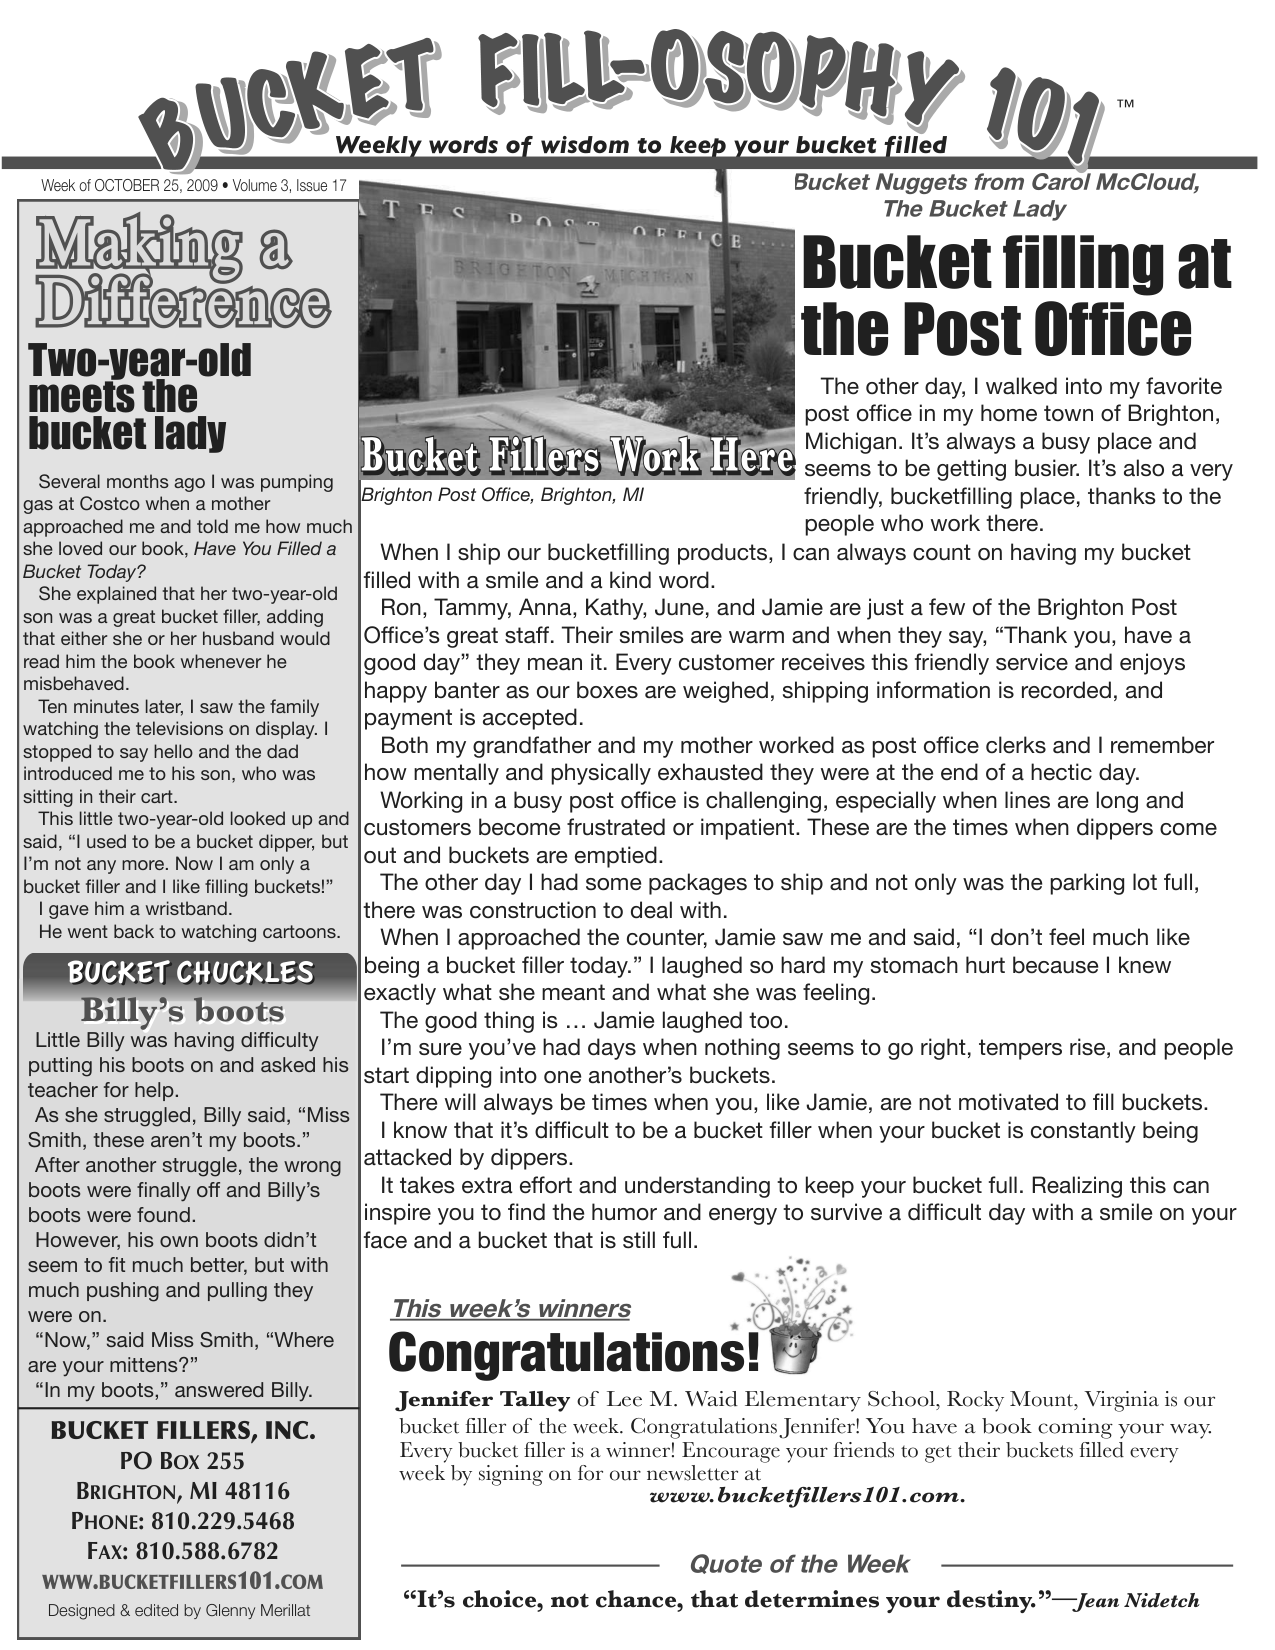

In [8]:
# Define the splits properly
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

# Inspect first training example
print("\nFirst training example:")
example = train_dataset[0]

print(f"Source: {example['source']}")
print(f"Question: {example['question']}")
print(f"Answer: {example['answer']}")  
print(f"Image field type: {type(example['image'])}")  
print(f"Image type: {type(example['image'])}")
print(f"Image size: {example['image'].size}")

# Display first image
print("\nFirst image:")
display(example['image']) 

In [9]:
# Explore dataset structure
print(f"Loaded - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"\nFeatures: {train_dataset.column_names}")

Loaded - Train: 17008, Val: 3647, Test: 3647

Features: ['image', 'question', 'answer', 'source']


In [10]:
# Examine samples from all splits
print("Examples:")
for i in range(min(2, len(train_dataset))):
    print(f"\n--- Train sample {i} ---")
    print(f"Question: {train_dataset[i]['question']}")
    print(f"Answer: {train_dataset[i]['answer']}") 
    print(f"Image: type={type(train_dataset[i]['image'])}, size={train_dataset[i]['image'].size}")

Examples:

--- Train sample 0 ---
Question: Q4:
Answer: From the document, it can be inferred that working in a busy post office can be challenging and physically and mentally exhausting, but positive attitudes and bucket filling can help overcome these difficulties.
Image: type=<class 'PIL.PngImagePlugin.PngImageFile'>, size=(1275, 1650)

--- Train sample 1 ---
Question: Which organizations' recommendations are being followed by the Villas management in terms of COVID-19 status updates?
Answer: The recommendations being followed by the Villas management include the Centers for Disease Control (CDC), Centers for Medicare and Medicaid Services (CMS), and the Pennsylvania Department of Health (PA DOH).
Image: type=<class 'PIL.PngImagePlugin.PngImageFile'>, size=(1275, 1650)


Train images:
Image: type=<class 'PIL.PngImagePlugin.PngImageFile'>, size=(1275, 1650)

--- Image ---


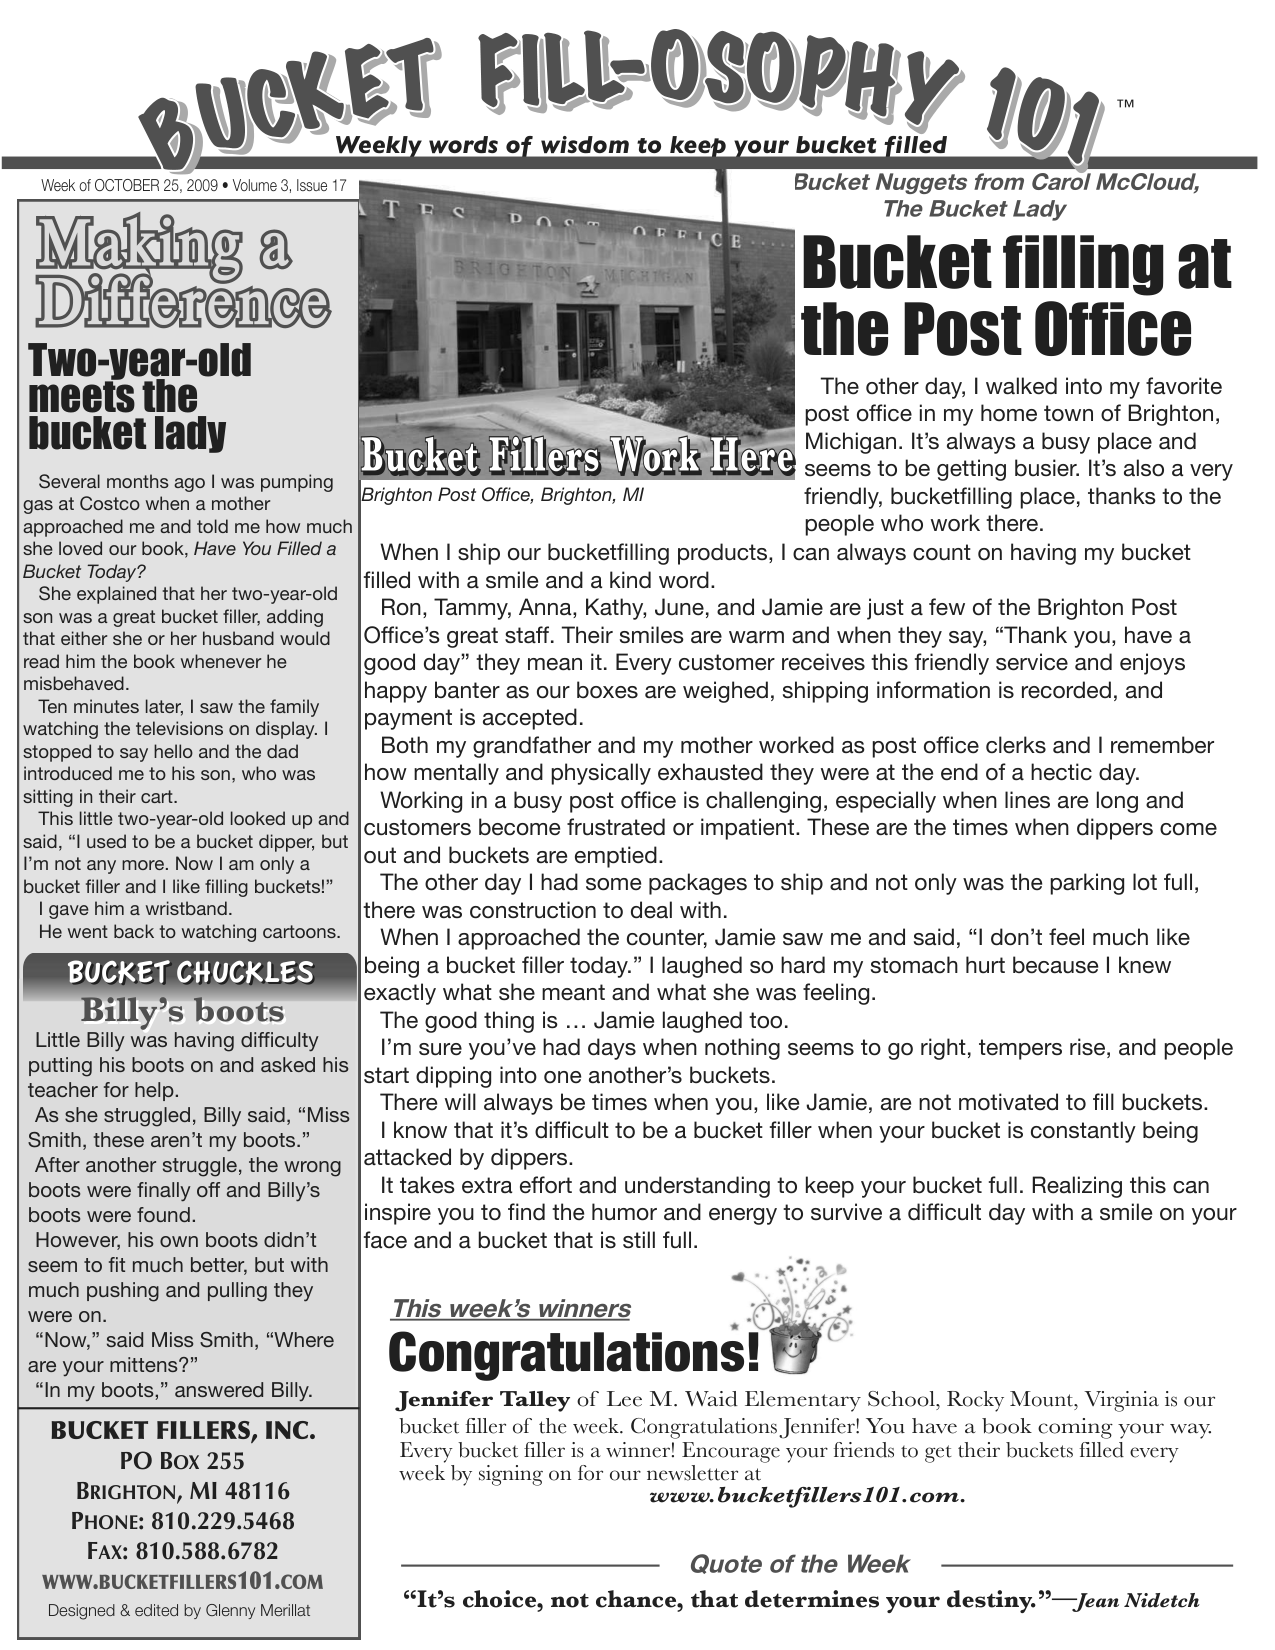

Question: Q4:
Answer: From the document, it can be inferred that working in a busy post office can be challenging and physically and mentally exhausting, but positive attitudes and bucket filling can help overcome these difficulties.


In [11]:
# Display example images
from IPython.display import display

print("Train images:")
if len(train_dataset) > 0:
    sample = train_dataset[0]
    print(f"Image: type={type(sample['image'])}, size={sample['image'].size}")
    print("\n--- Image ---")
    display(sample['image']) 
    print(f"Question: {sample['question']}")
    print(f"Answer: {sample['answer']}") 

In [10]:
def convert_to_conversation(batch):
    instruction = (
        "Analyze the document image and answer the question. "
        "The document may contain text in Russian or English. "
        "Provide your answer in the same language as the question."
    )
    
    messages_batch = []
    for i in range(len(batch["question"])):
        conversation = [
            { 
                "role": "user",
                "content": [
                    {"type": "image", "image": batch["image"][i]},
                    {"type": "text", "text": f"{instruction}\n\nQuestion: {batch['question'][i]}"}
                ]
            },
            { 
                "role": "assistant",
                "content": [
                    {"type": "text", "text": batch["answer"][i]} 
                ]
            },
        ]
        messages_batch.append(conversation)
    
    return {"messages": messages_batch}

In [11]:
print("Converting train dataset...")
train_converted = train_dataset.map(
    convert_to_conversation,
    batched=True,
    batch_size=50,
    remove_columns=train_dataset.column_names,
    num_proc=os.cpu_count()
)

print("Converting validation dataset...")
val_converted = val_dataset.map(
    convert_to_conversation,
    batched=True, 
    batch_size=50,
    remove_columns=val_dataset.column_names,
    num_proc=os.cpu_count()
)

print("Converting test dataset...")
test_converted = test_dataset.map(
    convert_to_conversation,
    batched=True,
    batch_size=50,
    remove_columns=test_dataset.column_names,
    num_proc=os.cpu_count()
)

print(f"Converted - Train: {len(train_converted)}, Val: {len(val_converted)}, Test: {len(test_converted)}")

Converting train dataset...
Converting validation dataset...
Converting test dataset...
Converted - Train: 17008, Val: 3647, Test: 3647


In [12]:
def convert_to_conversation(example):
    instruction = (
        "Analyze the document image and answer the question. "
        "The document may contain text in Russian or English. "
        "Provide your answer in the same language as the question."
    )
    
    conversation = [
        { 
            "role": "user",
            "content": [
                {"type": "image", "image": example["image"]},
                {"type": "text", "text": f"{instruction}\n\nQuestion: {example['question']}"}
            ]
        },
        { 
            "role": "assistant",
            "content": [
                {"type": "text", "text": example["answer"]} 
            ]
        },
    ]
    return {"messages": conversation}

In [13]:
train_converted = [convert_to_conversation(sample) for sample in train_dataset]
val_converted = [convert_to_conversation(sample) for sample in val_dataset] 
test_converted = [convert_to_conversation(sample) for sample in test_dataset]

print(f"Converted - Train: {len(train_converted)}, Val: {len(val_converted)}, Test: {len(test_converted)}")

Converted - Train: 17008, Val: 3647, Test: 3647


In [14]:
print("Checking first converted example:")
sample = train_converted[0]
print(sample)

Checking first converted example:
{'messages': [{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=1275x1650 at 0x7F27AAE46560>}, {'type': 'text', 'text': 'Analyze the document image and answer the question. The document may contain text in Russian or English. Provide your answer in the same language as the question.\n\nQuestion: Q4:'}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'From the document, it can be inferred that working in a busy post office can be challenging and physically and mentally exhausting, but positive attitudes and bucket filling can help overcome these difficulties.'}]}]}


In [13]:
print("Converting train dataset...")
train_converted = train_dataset.map(
    convert_to_conversation,
    batched=False, 
    remove_columns=train_dataset.column_names,
    num_proc=4
)

print("Converting validation dataset...")
val_converted = val_dataset.map(
    convert_to_conversation,
    batched=False, 
    remove_columns=val_dataset.column_names,
    num_proc=4
)

print("Converting test dataset...")
test_converted = test_dataset.map(
    convert_to_conversation,
    batched=False,
    remove_columns=test_dataset.column_names,
    num_proc=4
)

print(f"Converted - Train: {len(train_converted)}, Val: {len(val_converted)}, Test: {len(test_converted)}")

Converting train dataset...


Map (num_proc=4): 100%|██████████| 17008/17008 [1:09:35<00:00,  4.07 examples/s]  

Converting validation dataset...



Map (num_proc=4): 100%|██████████| 3647/3647 [15:46<00:00,  3.85 examples/s] 


Converting test dataset...


Map (num_proc=4): 100%|██████████| 3647/3647 [14:39<00:00,  4.15 examples/s] 

Converted - Train: 17008, Val: 3647, Test: 3647


In [8]:
from datasets import DatasetDict

# Создаем DatasetDict из конвертированных данных
final_dataset = DatasetDict({
    'train': train_converted,
    'validation': val_converted, 
    'test': test_converted
})

print("\nAll splits processed and combined!")
print("Final dataset structure:")
print(final_dataset)

output_path = "/home/jupyter/datasphere/project/processed_docvqa_instructedV3"
print(f"\nSaving final dataset to {output_path}...")
final_dataset.save_to_disk(output_path)
print("Dataset saved successfully. You can now load it instantly using `load_from_disk`.") 


All splits processed and combined!
Final dataset structure:
DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 17008
    })
    validation: Dataset({
        features: ['messages'],
        num_rows: 3647
    })
    test: Dataset({
        features: ['messages'],
        num_rows: 3647
    })
})

Saving final dataset to /home/jupyter/datasphere/project/processed_docvqa_instructedV2...


Saving the dataset (2/2 shards): 100%|██████████| 3647/3647 [00:41<00:00, 88.79 examples/s] 

Dataset saved successfully. You can now load it instantly using `load_from_disk`.


In [ ]:
from datasets import load_from_disk, DatasetDict
from IPython.display import display
from PIL import Image
import io
import time

processed_dataset_path = "/home/jupyter/datasphere/project/processed_docvqa_instructedV3"
print("Loading preprocessed dataset from disk...")
final_dataset = load_from_disk(processed_dataset_path)
print("Dataset loaded successfully!")

print(f"\nDataset info:")
print(f"Train samples: {len(final_dataset['train'])}")
print(f"Validation samples: {len(final_dataset['validation'])}")
print(f"Test samples: {len(final_dataset['test'])}")

# Функция для конвертации bytes в PIL.Image
def convert_image_data(image_data):
    """Конвертирует image data в PIL.Image"""
    if isinstance(image_data, dict) and 'bytes' in image_data:
        return Image.open(io.BytesIO(image_data['bytes']))
    return image_data

# Конвертируем первый пример для отображения
train_example = final_dataset['train'][0]
print(f"\nFirst example keys: {list(train_example.keys())}")

print("\nDisplaying the first image:")
first_image_content = train_example['messages'][0]['content'][0]
converted_image = convert_image_data(first_image_content['image'])
print(f"Image type after conversion: {type(converted_image)}")

if isinstance(converted_image, Image.Image):
    print(f"Image size: {converted_image.size}")
    display_size = (400, 520)
    resized_image = converted_image.resize(display_size, Image.Resampling.LANCZOS)
    display(resized_image)

print("\nAssociated data: ")
question = [c['text'] for c in train_example['messages'][0]['content'] if c['type'] == 'text'][0]
answer = train_example['messages'][1]['content'][0]['text']
print(f"Question: {question}")
print(f"Answer: {answer[:150]}...")

# Конвертируем ВЕСЬ датасет для обучения - ПРОСТОЙ ВАРИАНТ
def convert_dataset_images(dataset, desc="Converting images"):
    """Конвертирует все изображения в датасете"""
    def convert_example(example):
        for message in example['messages']:
            for content in message['content']:
                if content['type'] == 'image':
                    content['image'] = convert_image_data(content['image'])
        return example
    
    return dataset.map(
        convert_example, 
        batched=False, 
        num_proc=8, 
        load_from_cache_file=False,
        desc=desc
    )

print("\nConverting entire dataset for training...")
print("Converting train dataset...")
train_converted = convert_dataset_images(final_dataset["train"], "Converting train images")

print("Converting validation dataset...")  
val_converted = convert_dataset_images(final_dataset["validation"], "Converting validation images")

print("Converting test dataset...")
test_converted = convert_dataset_images(final_dataset["test"], "Converting test images")

final_dataset = DatasetDict({
    'train': train_converted,
    'validation': val_converted,
    'test': test_converted
})

print("Dataset conversion completed!")

print(f"\nVariables assigned:")
print(f"train_dataset: {len(train_converted)} samples")
print(f"val_dataset: {len(val_converted)} samples")
print(f"test_dataset: {len(test_converted)} samples")

# Финальная проверка
sample_check = train_converted[0]
image_check = sample_check['messages'][0]['content'][0]['image']
print(f"\nFinal check - Image type: {type(image_check)}")

In [15]:
# Show example of converted conversation
print("Example of converted conversation:")
if len(train_converted) > 0:
    sample = train_converted[0]
    print(f"Keys: {list(sample.keys())}")
    for i, message in enumerate(sample['messages']):
        print(f"Message {i}: role={message['role']}")
        print(f"Number of content items: {len(message['content'])}")
        for j, content in enumerate(message['content']):
            if content['type'] == 'image':
                img = content['image']
                print(f"  Content {j}: type=image, size={img.size}")
            else:
                text_preview = content['text'][:100] + "..." if len(content['text']) > 100 else content['text']
                print(f"  Content {j}: type=text, text={text_preview}")

Example of converted conversation:
Keys: ['messages']
Message 0: role=user
Number of content items: 2
  Content 0: type=image, size=(1275, 1650)
  Content 1: type=text, text=Analyze the document image and answer the question. The document may contain text in Russian or Engl...
Message 1: role=assistant
Number of content items: 1
  Content 0: type=text, text=From the document, it can be inferred that working in a busy post office can be challenging and phys...


In [16]:
FastVisionModel.for_inference(model) # Enable for inference!
 
# Test before training 
if len(train_converted) > 0:
    # Use the first sample for testing
    test_sample = train_converted[0]
    
    user_content = test_sample["messages"][0]["content"]
    image = [c["image"] for c in user_content if c["type"] == "image"][0]
    question_instruct = [c["text"] for c in user_content if c["type"] == "text"][0]
    true_answer = test_sample["messages"][1]["content"][0]["text"]

    messages = [
        {"role": "user", "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question_instruct}
        ]}
    ]
    
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    
    inputs = tokenizer(
        image,  
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)

    print(f"Question: {question_instruct}")
    print(f"True answer: {true_answer}")
    print("Model response:")
    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=256,
                       use_cache=True, temperature=0.7, min_p=0.1) 

Question: Analyze the document image and answer the question. The document may contain text in Russian or English. Provide your answer in the same language as the question.

Question: Q4:
True answer: From the document, it can be inferred that working in a busy post office can be challenging and physically and mentally exhausting, but positive attitudes and bucket filling can help overcome these difficulties.
Model response:
The question "Q4" is incomplete, so I will provide an analysis of the content in the document based on the information provided. If you can clarify the specific question related to the content, I can refine my response accordingly.

### Analysis of the Document:
The document is titled **"Bucket Fill-osophy 101"**, which appears to be a newsletter focused on spreading positive messages and encouraging people to engage in acts of kindness and bucket-filling (a concept where individuals try to uplift others' spirits by performing kind acts). Here's a breakdown of the 

In [17]:
# Calculate optimal steps
total_samples = len(train_converted)
batch_size = 2
grad_accumulation = 4
effective_batch_size = batch_size * grad_accumulation

steps_per_epoch = total_samples // effective_batch_size
max_steps = steps_per_epoch * 2

print(f"Training configuration:")
print(f"Total samples: {total_samples}")
print(f"Effective batch size: {effective_batch_size}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Max steps: {max_steps}")

Training configuration:
Total samples: 17008
Effective batch size: 8
Steps per epoch: 2126
Max steps: 4252


In [18]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

output_dir = "/home/jupyter/datasphere/project/qwen2.5-vl-32b-qlora-a100"

# Training with validation
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = train_converted,
    eval_dataset = val_converted,  
    args = SFTConfig(
        per_device_train_batch_size = batch_size, # 2
        gradient_accumulation_steps = grad_accumulation, # 4
        max_steps = max_steps, 
        learning_rate = 2e-5,
        warmup_steps = 300,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        logging_steps = 100,
        eval_steps = 500,  
        save_steps = 500,
        eval_strategy = "steps",  
        seed = 3407,
        output_dir = output_dir,
        report_to = "none",
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
        
        # Настройки для правильного shuffling и батчинга
        dataloader_drop_last=False,     
        dataloader_num_workers=14,        # Параллельная загрузка данных
        dataloader_pin_memory=True,      
        dataloader_prefetch_factor=4,    # Предзагрузка батчей
    ),
)

Unsloth: Model does not have a default image size - using 512


In [19]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-80GB. Max memory = 79.325 GB.
30.613 GB of memory reserved.


In [20]:
print(f"Train: {len(train_converted)} samples")
print(f"Validation: {len(val_converted)} samples") 
print(f"Test: {len(test_converted)} samples")
print(f"Steps: {max_steps}")

Train: 17008 samples
Validation: 3647 samples
Test: 3647 samples
Steps: 4252


In [ ]:
trainer_stats = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 17,008 | Num Epochs = 2 | Total steps = 4,252
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 145,424,384 of 33,598,142,720 (0.43% trained)
  0%|          | 0/4252 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/toke

Unsloth: Will smartly offload gradients to save VRAM!


  2%|▏         | 100/4252 [10:59<7:36:15,  6.59s/it]

{'loss': 0.9635, 'grad_norm': 1.182534098625183, 'learning_rate': 6.600000000000001e-06, 'epoch': 0.05}


  5%|▍         | 200/4252 [21:16<6:50:26,  6.08s/it]

{'loss': 0.2394, 'grad_norm': 0.3486982583999634, 'learning_rate': 1.3266666666666668e-05, 'epoch': 0.09}


  7%|▋         | 300/4252 [31:26<6:29:55,  5.92s/it]

{'loss': 0.1334, 'grad_norm': 0.2673708498477936, 'learning_rate': 1.9933333333333334e-05, 'epoch': 0.14}


  9%|▉         | 400/4252 [41:36<6:45:58,  6.32s/it]

{'loss': 0.1256, 'grad_norm': 0.30478906631469727, 'learning_rate': 1.9969048471195246e-05, 'epoch': 0.19}


 12%|█▏        | 500/4252 [51:59<6:19:33,  6.07s/it]

{'loss': 0.1186, 'grad_norm': 0.241288423538208, 'learning_rate': 1.9875136311162334e-05, 'epoch': 0.24}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'eval_loss': 0.4527720808982849, 'eval_runtime': 921.7539, 'eval_samples_per_second': 3.957, 'eval_steps_per_second': 0.989, 'epoch': 0.24}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 21f8cafb-c8a0-48ae-b919-a0a170612f26)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen2.5-vl-32b-instruct-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].
 14%|█▍        | 600/4252 [1:19:08<6:40:23,  6.58s/it]   

{'loss': 0.1159, 'grad_norm': 0.3457590341567993, 'learning_rate': 1.9718853502700783e-05, 'epoch': 0.28}


 16%|█▋        | 700/4252 [1:29:26<5:50:01,  5.91s/it]

{'loss': 0.1153, 'grad_norm': 0.2750333249568939, 'learning_rate': 1.9501187116752694e-05, 'epoch': 0.33}


 19%|█▉        | 800/4252 [1:39:37<5:41:48,  5.94s/it]

{'loss': 0.1161, 'grad_norm': 0.23978663980960846, 'learning_rate': 1.92235119185066e-05, 'epoch': 0.38}


 21%|██        | 900/4252 [1:49:48<5:37:33,  6.04s/it]

{'loss': 0.109, 'grad_norm': 0.32223618030548096, 'learning_rate': 1.8887581684479762e-05, 'epoch': 0.42}


 24%|██▎       | 1000/4252 [1:59:58<5:56:34,  6.58s/it]

{'loss': 0.1067, 'grad_norm': 0.36800798773765564, 'learning_rate': 1.8495518125792187e-05, 'epoch': 0.47}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'eval_loss': 0.42356377840042114, 'eval_runtime': 919.2753, 'eval_samples_per_second': 3.967, 'eval_steps_per_second': 0.992, 'epoch': 0.47}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 74243157-67b2-4df0-8af7-fbdc8c7ff770)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen2.5-vl-32b-instruct-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].
 26%|██▌       | 1100/4252 [2:27:16<5:35:17,  6.38s/it]   

{'loss': 0.1091, 'grad_norm': 0.385927677154541, 'learning_rate': 1.8049797487592307e-05, 'epoch': 0.52}


 28%|██▊       | 1200/4252 [2:37:40<4:52:14,  5.75s/it]

{'loss': 0.1073, 'grad_norm': 0.4527267515659332, 'learning_rate': 1.755323490927127e-05, 'epoch': 0.56}


 31%|███       | 1300/4252 [2:48:10<5:59:08,  7.30s/it]

{'loss': 0.1108, 'grad_norm': 0.20869342982769012, 'learning_rate': 1.700896664424568e-05, 'epoch': 0.61}


 33%|███▎      | 1400/4252 [2:58:34<5:24:29,  6.83s/it]

{'loss': 0.1031, 'grad_norm': 0.2178414911031723, 'learning_rate': 1.6420430251607293e-05, 'epoch': 0.66}


 35%|███▌      | 1500/4252 [3:08:37<4:19:10,  5.65s/it]

{'loss': 0.1022, 'grad_norm': 0.23852890729904175, 'learning_rate': 1.5791342884747825e-05, 'epoch': 0.71}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'eval_loss': 0.40643420815467834, 'eval_runtime': 919.8156, 'eval_samples_per_second': 3.965, 'eval_steps_per_second': 0.992, 'epoch': 0.71}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ed7286f5-75de-4bfb-bdbd-880cd13f1c1a)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen2.5-vl-32b-instruct-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].
 38%|███▊      | 1600/4252 [3:35:45<4:18:20,  5.84s/it]   

{'loss': 0.1037, 'grad_norm': 0.29820573329925537, 'learning_rate': 1.5125677814086337e-05, 'epoch': 0.75}


 40%|███▉      | 1700/4252 [3:46:01<4:14:48,  5.99s/it]

{'loss': 0.1065, 'grad_norm': 0.29024073481559753, 'learning_rate': 1.442763933217993e-05, 'epoch': 0.8}


 42%|████▏     | 1800/4252 [3:56:39<4:20:36,  6.38s/it]

{'loss': 0.103, 'grad_norm': 0.3230856955051422, 'learning_rate': 1.3701636199715327e-05, 'epoch': 0.85}


 45%|████▍     | 1900/4252 [4:07:10<3:57:50,  6.07s/it]

{'loss': 0.1086, 'grad_norm': 0.28310301899909973, 'learning_rate': 1.2952253800094467e-05, 'epoch': 0.89}


 47%|████▋     | 2000/4252 [4:17:44<3:49:47,  6.12s/it]

{'loss': 0.0981, 'grad_norm': 0.3783700466156006, 'learning_rate': 1.218422517848377e-05, 'epoch': 0.94}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'eval_loss': 0.3952631950378418, 'eval_runtime': 919.9485, 'eval_samples_per_second': 3.964, 'eval_steps_per_second': 0.991, 'epoch': 0.94}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 7b6b4e67-1146-4aba-bac2-548f998d8290)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen2.5-vl-32b-instruct-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].
 49%|████▉     | 2100/4252 [4:44:46<3:25:59,  5.74s/it]   

{'loss': 0.1003, 'grad_norm': 0.43582063913345337, 'learning_rate': 1.1402401148242391e-05, 'epoch': 0.99}


 50%|████▉     | 2125/4252 [4:47:24<3:35:59,  6.09s/it]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 50%|█████     | 2126/4252 [4:47:30<3:37:41,  6.14s/it]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible

{'loss': 0.1018, 'grad_norm': 0.362454891204834, 'learning_rate': 1.0611719653535015e-05, 'epoch': 1.03}


 54%|█████▍    | 2300/4252 [5:05:43<3:50:19,  7.08s/it]

{'loss': 0.0974, 'grad_norm': 0.29764723777770996, 'learning_rate': 9.817174581632824e-06, 'epoch': 1.08}


 56%|█████▋    | 2400/4252 [5:15:54<3:06:03,  6.03s/it]

{'loss': 0.0958, 'grad_norm': 0.3883435130119324, 'learning_rate': 9.02378422188179e-06, 'epoch': 1.13}


 59%|█████▉    | 2500/4252 [5:26:16<2:59:50,  6.16s/it]

{'loss': 0.0992, 'grad_norm': 0.43497905135154724, 'learning_rate': 8.236559570549246e-06, 'epoch': 1.18}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'eval_loss': 0.38879767060279846, 'eval_runtime': 920.7337, 'eval_samples_per_second': 3.961, 'eval_steps_per_second': 0.991, 'epoch': 1.18}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 64fa6857-bf7e-4352-9a83-3fd9b1279ac7)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen2.5-vl-32b-instruct-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].
 61%|██████    | 2600/4252 [5:53:26<3:07:40,  6.82s/it]   

{'loss': 0.0931, 'grad_norm': 0.25364503264427185, 'learning_rate': 7.460472681733031e-06, 'epoch': 1.22}


 63%|██████▎   | 2700/4252 [6:03:31<2:49:14,  6.54s/it]

{'loss': 0.0985, 'grad_norm': 0.30962565541267395, 'learning_rate': 6.700425264226549e-06, 'epoch': 1.27}


 66%|██████▌   | 2800/4252 [6:13:49<2:34:33,  6.39s/it]

{'loss': 0.0941, 'grad_norm': 0.3398989140987396, 'learning_rate': 5.961217722679684e-06, 'epoch': 1.32}


 68%|██████▊   | 2900/4252 [6:24:14<2:21:20,  6.27s/it]

{'loss': 0.0974, 'grad_norm': 0.4046004116535187, 'learning_rate': 5.24751883858941e-06, 'epoch': 1.36}


 71%|███████   | 3000/4252 [6:34:40<2:04:50,  5.98s/it]

{'loss': 0.0936, 'grad_norm': 1.0283819437026978, 'learning_rate': 4.563836282612698e-06, 'epoch': 1.41}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'eval_loss': 0.3834206163883209, 'eval_runtime': 920.5065, 'eval_samples_per_second': 3.962, 'eval_steps_per_second': 0.991, 'epoch': 1.41}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 26ab080a-ec8a-44ca-9999-2d2c4fa03a2e)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen2.5-vl-32b-instruct-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].
 73%|███████▎  | 3100/4252 [7:01:56<1:59:52,  6.24s/it]   

{'loss': 0.0926, 'grad_norm': 0.3767213225364685, 'learning_rate': 3.914488144443916e-06, 'epoch': 1.46}


 75%|███████▌  | 3200/4252 [7:12:18<1:43:10,  5.88s/it]

{'loss': 0.096, 'grad_norm': 0.5698354840278625, 'learning_rate': 3.3035756600718515e-06, 'epoch': 1.51}


 78%|███████▊  | 3300/4252 [7:22:33<1:37:50,  6.17s/it]

{'loss': 0.0941, 'grad_norm': 0.42600294947624207, 'learning_rate': 2.7349573086691215e-06, 'epoch': 1.55}


 80%|███████▉  | 3400/4252 [7:32:53<1:24:18,  5.94s/it]

{'loss': 0.0959, 'grad_norm': 0.530616283416748, 'learning_rate': 2.2122244427161356e-06, 'epoch': 1.6}


 82%|████████▏ | 3500/4252 [7:43:16<1:15:09,  6.00s/it]

{'loss': 0.0946, 'grad_norm': 0.40885475277900696, 'learning_rate': 1.738678605277928e-06, 'epoch': 1.65}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'eval_loss': 0.3812223970890045, 'eval_runtime': 922.357, 'eval_samples_per_second': 3.954, 'eval_steps_per_second': 0.989, 'epoch': 1.65}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 380a6e74-da45-4f2a-954e-805cb90b2c61)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen2.5-vl-32b-instruct-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].
 85%|████████▍ | 3600/4252 [8:10:33<1:06:01,  6.08s/it]  

{'loss': 0.0954, 'grad_norm': 1.2271853685379028, 'learning_rate': 1.3173106776963961e-06, 'epoch': 1.69}


 87%|████████▋ | 3700/4252 [8:20:54<55:15,  6.01s/it]  

{'loss': 0.0964, 'grad_norm': 0.40784627199172974, 'learning_rate': 9.507819893995285e-07, 'epoch': 1.74}


 89%|████████▉ | 3800/4252 [8:31:11<46:59,  6.24s/it]  

{'loss': 0.0964, 'grad_norm': 0.35087791085243225, 'learning_rate': 6.414075091367567e-07, 'epoch': 1.79}


 92%|█████████▏| 3900/4252 [8:41:33<39:29,  6.73s/it]

{'loss': 0.0931, 'grad_norm': 0.4124884307384491, 'learning_rate': 3.9114122380338183e-07, 'epoch': 1.83}


 94%|█████████▍| 4000/4252 [8:52:05<25:23,  6.05s/it]

{'loss': 0.0956, 'grad_norm': 0.3700354993343353, 'learning_rate': 2.0156379720030706e-07, 'epoch': 1.88}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'eval_loss': 0.3803551495075226, 'eval_runtime': 922.899, 'eval_samples_per_second': 3.952, 'eval_steps_per_second': 0.988, 'epoch': 1.88}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 7e2af349-ee86-4648-b4af-9796ddd8a82b)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen2.5-vl-32b-instruct-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].
 96%|█████████▋| 4100/4252 [9:19:24<14:57,  5.90s/it]    

{'loss': 0.092, 'grad_norm': 0.5806533098220825, 'learning_rate': 7.387258667553188e-08, 'epoch': 1.93}


 99%|█████████▉| 4200/4252 [9:29:50<06:19,  7.30s/it]

{'loss': 0.0941, 'grad_norm': 0.24963435530662537, 'learning_rate': 8.874080701533062e-09, 'epoch': 1.98}


100%|██████████| 4252/4252 [9:35:12<00:00,  6.13s/it]'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 75b86634-0031-4d71-8389-f0d63d4afe15)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen2.5-vl-32b-instruct-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].
100%|██████████| 4252/4252 [9:36:39<00:00,  8.14s/it]

{'train_runtime': 34599.5582, 'train_samples_per_second': 0.983, 'train_steps_per_second': 0.123, 'train_loss': 0.12593259154236328, 'epoch': 2.0}


In [22]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

print(f"Training time: {trainer_stats.metrics['train_runtime']:.2f} seconds")
print(f"Training time: {round(trainer_stats.metrics['train_runtime']/60, 2)} minutes")
print(f"Peak memory: {used_memory} GB")
print(f"Memory for QLoRA: {used_memory_for_lora} GB")

Training time: 34599.56 seconds
Training time: 576.66 minutes
Peak memory: 30.613 GB
Memory for QLoRA: 0.0 GB


In [24]:
# Final model evaluation
FastVisionModel.for_inference(model)

print("Final Model Evaluation")

def evaluate_dataset(dataset_converted, dataset_name, num_samples=3):
    print(f"\n{dataset_name} dataset evaluation:")
    
    import random
    indices = random.sample(range(len(dataset_converted)), min(num_samples, len(dataset_converted)))
    
    for i, idx in enumerate(indices):
        test_sample = dataset_converted[idx]

        user_content = test_sample["messages"][0]["content"]
        image = [content['image'] for content in user_content if content['type'] == 'image'][0]  # ОДНА картинка
        question_instruct = [content['text'] for content in user_content if content['type'] == 'text'][0]
        true_answer = test_sample["messages"][1]["content"][0]["text"]

        messages = [
            {"role": "user", "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": question_instruct}
            ]}
        ]

        input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
        inputs = tokenizer(
            image,
            input_text,
            add_special_tokens=False,
            return_tensors="pt",
        ).to("cuda")

        text_streamer = TextStreamer(tokenizer, skip_prompt=True)

        print(f"\nSample {i+1}:")
        print(f"Question: {question_instruct}")
        print(f"True answer: {true_answer}")
        print("Model response:")
        _ = model.generate(
            **inputs, 
            streamer=text_streamer, 
            max_new_tokens=256,
            use_cache=True, 
            temperature=0.7, 
            min_p=0.1,
            pad_token_id=tokenizer.eos_token_id
        )

# Evaluate on all datasets
evaluate_dataset(train_converted, "Train", num_samples=2)
evaluate_dataset(val_converted, "Validation", num_samples=2)  
evaluate_dataset(test_converted, "Test", num_samples=2)

print("\nEvaluation completed") 

Final Model Evaluation

Train dataset evaluation:

Sample 1:
Question: Analyze the document image and answer the question. The document may contain text in Russian or English. Provide your answer in the same language as the question.

Question: What is the title of the book about Benedict XVI's life and challenges, and when was his ordination anniversary celebrated?
True answer: The title of the book is "Benedetto XVI: La vita e le sfide," and it was written to celebrate Benedict XVI's 70th ordination anniversary.
Model response:
The title of the book is "Benedetto XVI: La vita e le sfide," and his 70th ordination anniversary was celebrated recently.<|im_end|>

Sample 2:
Question: Analyze the document image and answer the question. The document may contain text in Russian or English. Provide your answer in the same language as the question.

Question: Где в документе расположено число "135101"? Выведи абсолютные координаты (в пикселях) левого верхнего и правого нижнего углов ограничива

In [25]:
# @title Save Model
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"QLoRA model saved to: {output_dir}")

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 075aab42-149a-4d7f-b4cd-f0a539468b35)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen2.5-vl-32b-instruct-bnb-4bit/resolve/main/config.json
Retrying in 1s [Retry 1/5].


QLoRA model saved to: /home/jupyter/datasphere/project/qwen2.5-vl-32b-qlora-a100


In [33]:
import os
if os.path.exists(output_dir):
    files = os.listdir(output_dir)
    print(f"Files in {output_dir}: {files}")
else:
    print(f"Directory {output_dir} does not exist!")

Files in /home/jupyter/datasphere/project/qwen2.5-vl-32b-qlora: ['.ipynb_checkpoints', 'README.md', 'adapter_config.json', 'adapter_model.safetensors', 'added_tokens.json', 'chat_template.jinja', 'checkpoint-1000', 'merges.txt', 'preprocessor_config.json', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'video_preprocessor_config.json', 'vocab.json']


In [ ]:
# @title Load Model for Inference (set to True when needed)
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "qwen2.5-vl-32b-qlora",
        load_in_4bit = True,
    )
    FastVisionModel.for_inference(model)
    print("QLoRA model loaded for inference")

In [ ]:
# @title Save Merged Model (Optional)
# Save to 16bit
if False: 
    model.save_pretrained_merged(f"{output_dir}-merged", tokenizer)
    print(f"Merged model saved to: {merged_dir}")

In [ ]:
# Push to Hub
if False:
    model.push_to_hub_merged("your_username/qwen2.5-vl-32b-qlora", 
                           tokenizer, 
                           token = "your_hf_token")
    print("QLoRA model loaded to Hugging Face Hub")